In [197]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt


# Getting the same results with train and train_manual_update
- Write torch.manual_seed(42) at the beginning of your notebook.
- Write torch.set_default_dtype(torch.double) at the beginning of your notebook to alleviate precision errors

In [198]:
SEED = 265
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)
rng = torch.Generator().manual_seed(SEED)

# Tasks
Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3
datasets: training, validation and test. Take a subset of these datasets
by keeping only 2 labels: cat and car

In [199]:
def filter_classes(dataset, keep_classes):
    """Filter out samples from the dataset that do not belong to keep_classes and remap labels to 0 and 1."""
    class_map = {1: 0, 3: 1}  # Remap labels
    indices = [i for i, (_, label) in enumerate(dataset) if label in keep_classes]
   
    new_samples = [(dataset[i][0], class_map[dataset[i][1]]) for i in indices]
    
    return new_samples

def load_cifar(train_val_split=0.9, data_path="data", preprocessor=None):
        
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    # Load CIFAR10 dataset training and validation sets
    cifar10_train_val = datasets.CIFAR10(
    data_path,      
    train=True,     
    download=True,
    transform=preprocessor
    )

    cifar10_test = datasets.CIFAR10(
        data_path,
        train=False,
        download=True,
        transform=preprocessor
    )

    # Keep only classes 1 (automobile) and 3 (cat)
    keep_classes = {1, 3}
    cifar10_train_val = filter_classes(cifar10_train_val, keep_classes)
    cifar10_test = filter_classes(cifar10_test, keep_classes)

    # Split the training set into training and validation sets
    n_train_val = len(cifar10_train_val)
    n_train = int(n_train_val * (train_val_split))
    n_val = n_train_val - n_train 
    
    cifar10_train, cifar10_val = random_split(cifar10_train_val, lengths=[n_train, n_val], generator=rng)


    print(f"Number of training samples: {len(cifar10_train)}")
    print(f"Number of validation samples: {len(cifar10_val)}")
    print(f"Number of test samples: {len(cifar10_test)}")
   
    return cifar10_train, cifar10_val, cifar10_test


def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient tracking for validation
        for images, labels in loader:
            # Forward pass by passing the images through the model
            outputs = model.forward(images)
            preds = torch.argmax(outputs, dim=1) #index of the maximum value in each of the 64 images
            bool_tensor = torch.eq(preds, labels)
            correct += torch.sum(bool_tensor).item()
            total += preds.shape[0]
            
    accuracy = correct/total
    return accuracy

In [200]:
cifar_train, cifar_val, cifar_test = load_cifar()

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 9000
Number of validation samples: 1000
Number of test samples: 2000


## Data analysis and preprocessing
- Have you analysed the dataset? For example, can you answer the following questions:
- What do the input data and expected targets contained in the dataset represent?
- How is this data encoded?
- Does the dataset contain missing / extreme values?
- What does a typical input / output look like?
- Is the dataset normalized?
- Is the dataset balanced?
- Have you preprocessed the dataset according to your analysis of the dataset and domain knowledge?

In [201]:
# Get shape of a single image and its label
image, label = cifar_train[0]
print("Image shape:", image.shape)  # Should be (3, 16, 16)
print("Label (encoded as integer):", label)  # Should be 0 or 1


Image shape: torch.Size([3, 16, 16])
Label (encoded as integer): 1


Write a MyMLP class that implements a MLP in PyTorch (so only fully
connected layers) such that:
    
    - The input dimension is 768(= 16 ∗ 16 ∗ 3) and the output dimension is 2 (for the 2 classes).
    - The hidden layers have respectively 128 and 32 hidden units.
    - All activation functions are ReLU. The last layer has no activation function since the cross-entropy loss already includes a softmax activation function.

In [202]:
class MyMLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            torch.nn.Linear(16*16*3, 128), 
            torch.nn.ReLU(), 
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 2)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


Write a train(n_epochs, optimizer, model, loss_fn, train_loader) function that trains model for n_epochs epochs given an optimizer optimizer, a loss function loss_fn and a dataloader train_loader.

In [203]:
def train(optimizer, model, loss_fn, train_loader, n_epochs = 10):
    train_losses = []
    print("--------- Using Pytorch's SGD ---------")
    
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device=('cpu'), dtype=torch.double)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        if (epoch) == 1 or (epoch) % 5 == 0:
            print(f"(manual train) | Epoch {epoch} / {n_epochs} | Training Loss: {train_loss:.5f}")

    return train_losses


Write a similar function train manual_update that has no optimizer parameter, but a learning rate lr parameter instead and that manually updates each trainable parameter of model using equation (2). Do not forget to zero out all gradients after each iteration. 

Train 2 instances of MyMLP, one using train and the other using train_manual_update (use the same parameter values for both models). Compare their respective training losses. To get exactly the same results with both functions, see section 3.3

In [204]:
def train_manual_update(model, loss_fn, train_loader, lr=1e-2, momentum_coeff=0., weight_decay=0., n_epochs = 10):
    train_losses = []
    print("--------- Using manual update ----------")
    
    velocity = {p: torch.zeros_like(p) for p in model.parameters()}

    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device='cpu', dtype=torch.double)
            
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    # if weight_decay != 0:
                    #     p.grad += weight_decay * p.data
                    
                    #p.data -= lr * p.grad
                    grad_with_decay = p.grad + weight_decay * p.data
                    velocity[p] = momentum_coeff * velocity[p] - lr * grad_with_decay
                    p.data += velocity[p]


            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        #print epoch 1, 5, 10...
        if (epoch) == 1 or (epoch) % 5 == 0:
            print(f"(manual train) | Epoch {epoch} / {n_epochs} | Training Loss: {train_loss:.5f}")
        
    return train_losses
    

In [205]:
batch_size = 256

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=0)

loss_fn = nn.CrossEntropyLoss()

In [206]:
def train_and_validate(model, model_manuel, train_loader, val_loader, n_epochs=30, loss_fn=loss_fn, lr=0.01, weight_decay=0, momentum_coeff=0.):
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum_coeff)
    accuracies = {}
    
    train_losses = train(optimizer, model, loss_fn, train_loader, n_epochs)
    train_accuracy = compute_accuracy(model, train_loader)
    val_accuracy = compute_accuracy(model, val_loader)

    print()
    print("--- Accuracies ---")
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print()

    train_losses_manuel = train_manual_update(model_manuel, loss_fn, train_loader, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs, momentum_coeff=momentum_coeff)
    train_accuracy_manuel = compute_accuracy(model_manuel, train_loader)
    val_accuracy_manuel = compute_accuracy(model_manuel, val_loader)
    print()
    print("--- Accuracies ---")
    print(f"Train accuracy (manual): {train_accuracy_manuel:.4f}")
    print(f"Validation accuracy (manual): {val_accuracy_manuel:.4f}")

    accuracies['train'] = train_accuracy
    accuracies['val'] = val_accuracy
    accuracies['train_manuel'] = train_accuracy_manuel
    accuracies['val_manuel'] = val_accuracy_manuel

    return train_losses, train_losses_manuel, accuracies


In [207]:
results = []
accuracies = {}

In [208]:
torch.manual_seed(SEED)
model1_1 = MyMLP()
torch.manual_seed(SEED)
model1_2 = MyMLP()

train_losses_1, train_losses_manuel_1, accuracies1 = train_and_validate(model1_1, model1_2, train_loader, val_loader)
results.append((train_losses_1, train_losses_manuel_1))

accuracies[model1_1] = accuracies1 


--------- Using Pytorch's SGD ---------
(manual train) | Epoch 1 / 30 | Training Loss: 0.68815
(manual train) | Epoch 5 / 30 | Training Loss: 0.65521
(manual train) | Epoch 10 / 30 | Training Loss: 0.57305
(manual train) | Epoch 15 / 30 | Training Loss: 0.49053
(manual train) | Epoch 20 / 30 | Training Loss: 0.43565
(manual train) | Epoch 25 / 30 | Training Loss: 0.39573
(manual train) | Epoch 30 / 30 | Training Loss: 0.36121

--- Accuracies ---
Train accuracy: 0.8550
Validation accuracy: 0.8420

--------- Using manual update ----------
(manual train) | Epoch 1 / 30 | Training Loss: 0.68815
(manual train) | Epoch 5 / 30 | Training Loss: 0.65521
(manual train) | Epoch 10 / 30 | Training Loss: 0.57305
(manual train) | Epoch 15 / 30 | Training Loss: 0.49053
(manual train) | Epoch 20 / 30 | Training Loss: 0.43565
(manual train) | Epoch 25 / 30 | Training Loss: 0.39573
(manual train) | Epoch 30 / 30 | Training Loss: 0.36121

--- Accuracies ---
Train accuracy (manual): 0.8550
Validation accu

In [209]:
torch.manual_seed(SEED)
model2_1 = MyMLP()
torch.manual_seed(SEED)
model2_2 = MyMLP()

train_losses_2, train_losses_manuel_2, accuracies2= train_and_validate(model2_1, model2_2, train_loader, val_loader, weight_decay=0.01,  lr=0.01)
results.append((train_losses_2, train_losses_manuel_2))
accuracies[model2_1] = accuracies2

--------- Using Pytorch's SGD ---------
(manual train) | Epoch 1 / 30 | Training Loss: 0.68818
(manual train) | Epoch 5 / 30 | Training Loss: 0.65705
(manual train) | Epoch 10 / 30 | Training Loss: 0.58039
(manual train) | Epoch 15 / 30 | Training Loss: 0.50100
(manual train) | Epoch 20 / 30 | Training Loss: 0.44650
(manual train) | Epoch 25 / 30 | Training Loss: 0.40815
(manual train) | Epoch 30 / 30 | Training Loss: 0.37553

--- Accuracies ---
Train accuracy: 0.8484
Validation accuracy: 0.8320

--------- Using manual update ----------
(manual train) | Epoch 1 / 30 | Training Loss: 0.68818
(manual train) | Epoch 5 / 30 | Training Loss: 0.65705
(manual train) | Epoch 10 / 30 | Training Loss: 0.58039
(manual train) | Epoch 15 / 30 | Training Loss: 0.50100
(manual train) | Epoch 20 / 30 | Training Loss: 0.44650
(manual train) | Epoch 25 / 30 | Training Loss: 0.40815
(manual train) | Epoch 30 / 30 | Training Loss: 0.37553

--- Accuracies ---
Train accuracy (manual): 0.8484
Validation accu

In [210]:
torch.manual_seed(SEED)
model3_1 = MyMLP()
torch.manual_seed(SEED)
model3_2 = MyMLP()

train_losses_3, train_losses_manuel_3, accuracies3 = train_and_validate(model3_1, model3_2, train_loader, val_loader, momentum_coeff=0.9,  lr=0.01)
results.append((train_losses_3, train_losses_manuel_3))
accuracies[model3_1] = accuracies3


--------- Using Pytorch's SGD ---------
(manual train) | Epoch 1 / 30 | Training Loss: 0.67065
(manual train) | Epoch 5 / 30 | Training Loss: 0.33401
(manual train) | Epoch 10 / 30 | Training Loss: 0.21542
(manual train) | Epoch 15 / 30 | Training Loss: 0.15239
(manual train) | Epoch 20 / 30 | Training Loss: 0.10855
(manual train) | Epoch 25 / 30 | Training Loss: 0.07401
(manual train) | Epoch 30 / 30 | Training Loss: 0.05404

--- Accuracies ---
Train accuracy: 0.9802
Validation accuracy: 0.9210

--------- Using manual update ----------
(manual train) | Epoch 1 / 30 | Training Loss: 0.67065
(manual train) | Epoch 5 / 30 | Training Loss: 0.33401
(manual train) | Epoch 10 / 30 | Training Loss: 0.21542
(manual train) | Epoch 15 / 30 | Training Loss: 0.15239
(manual train) | Epoch 20 / 30 | Training Loss: 0.10855
(manual train) | Epoch 25 / 30 | Training Loss: 0.07401
(manual train) | Epoch 30 / 30 | Training Loss: 0.05404

--- Accuracies ---
Train accuracy (manual): 0.9802
Validation accu

In [211]:
torch.manual_seed(SEED)
model4_1 = MyMLP()
torch.manual_seed(SEED)
model4_2 = MyMLP()

train_losses_4, train_losses_manuel_4, accuracies4 = train_and_validate(model4_1, model4_2, train_loader, val_loader, momentum_coeff=0.9, weight_decay=0.001,  lr=0.01)
results.append((train_losses_4, train_losses_manuel_4))
accuracies[model4_1] = accuracies4

--------- Using Pytorch's SGD ---------
(manual train) | Epoch 1 / 30 | Training Loss: 0.67075
(manual train) | Epoch 5 / 30 | Training Loss: 0.33543
(manual train) | Epoch 10 / 30 | Training Loss: 0.21788
(manual train) | Epoch 15 / 30 | Training Loss: 0.15553
(manual train) | Epoch 20 / 30 | Training Loss: 0.11343
(manual train) | Epoch 25 / 30 | Training Loss: 0.07946
(manual train) | Epoch 30 / 30 | Training Loss: 0.05490

--- Accuracies ---
Train accuracy: 0.9789
Validation accuracy: 0.9240

--------- Using manual update ----------
(manual train) | Epoch 1 / 30 | Training Loss: 0.67075
(manual train) | Epoch 5 / 30 | Training Loss: 0.33543
(manual train) | Epoch 10 / 30 | Training Loss: 0.21788
(manual train) | Epoch 15 / 30 | Training Loss: 0.15553
(manual train) | Epoch 20 / 30 | Training Loss: 0.11343
(manual train) | Epoch 25 / 30 | Training Loss: 0.07946
(manual train) | Epoch 30 / 30 | Training Loss: 0.05490

--- Accuracies ---
Train accuracy (manual): 0.9789
Validation accu

In [212]:
torch.manual_seed(SEED)
model5_1 = MyMLP()
torch.manual_seed(SEED)
model5_2 = MyMLP()

train_losses_5, train_losses_manuel_5, accuracies5 = train_and_validate(model5_1, model5_2, train_loader, val_loader, momentum_coeff=0.9, weight_decay=0.001,  lr=0.05)
results.append((train_losses_5, train_losses_manuel_5))
accuracies[model5_1] = accuracies5

--------- Using Pytorch's SGD ---------
(manual train) | Epoch 1 / 30 | Training Loss: 0.56783
(manual train) | Epoch 5 / 30 | Training Loss: 0.21712
(manual train) | Epoch 10 / 30 | Training Loss: 0.12739
(manual train) | Epoch 15 / 30 | Training Loss: 0.15517
(manual train) | Epoch 20 / 30 | Training Loss: 0.06996
(manual train) | Epoch 25 / 30 | Training Loss: 0.08590
(manual train) | Epoch 30 / 30 | Training Loss: 0.04813

--- Accuracies ---
Train accuracy: 0.9688
Validation accuracy: 0.8950

--------- Using manual update ----------
(manual train) | Epoch 1 / 30 | Training Loss: 0.56783
(manual train) | Epoch 5 / 30 | Training Loss: 0.21712
(manual train) | Epoch 10 / 30 | Training Loss: 0.12739
(manual train) | Epoch 15 / 30 | Training Loss: 0.15517
(manual train) | Epoch 20 / 30 | Training Loss: 0.06996
(manual train) | Epoch 25 / 30 | Training Loss: 0.08590
(manual train) | Epoch 30 / 30 | Training Loss: 0.04813

--- Accuracies ---
Train accuracy (manual): 0.9688
Validation accu

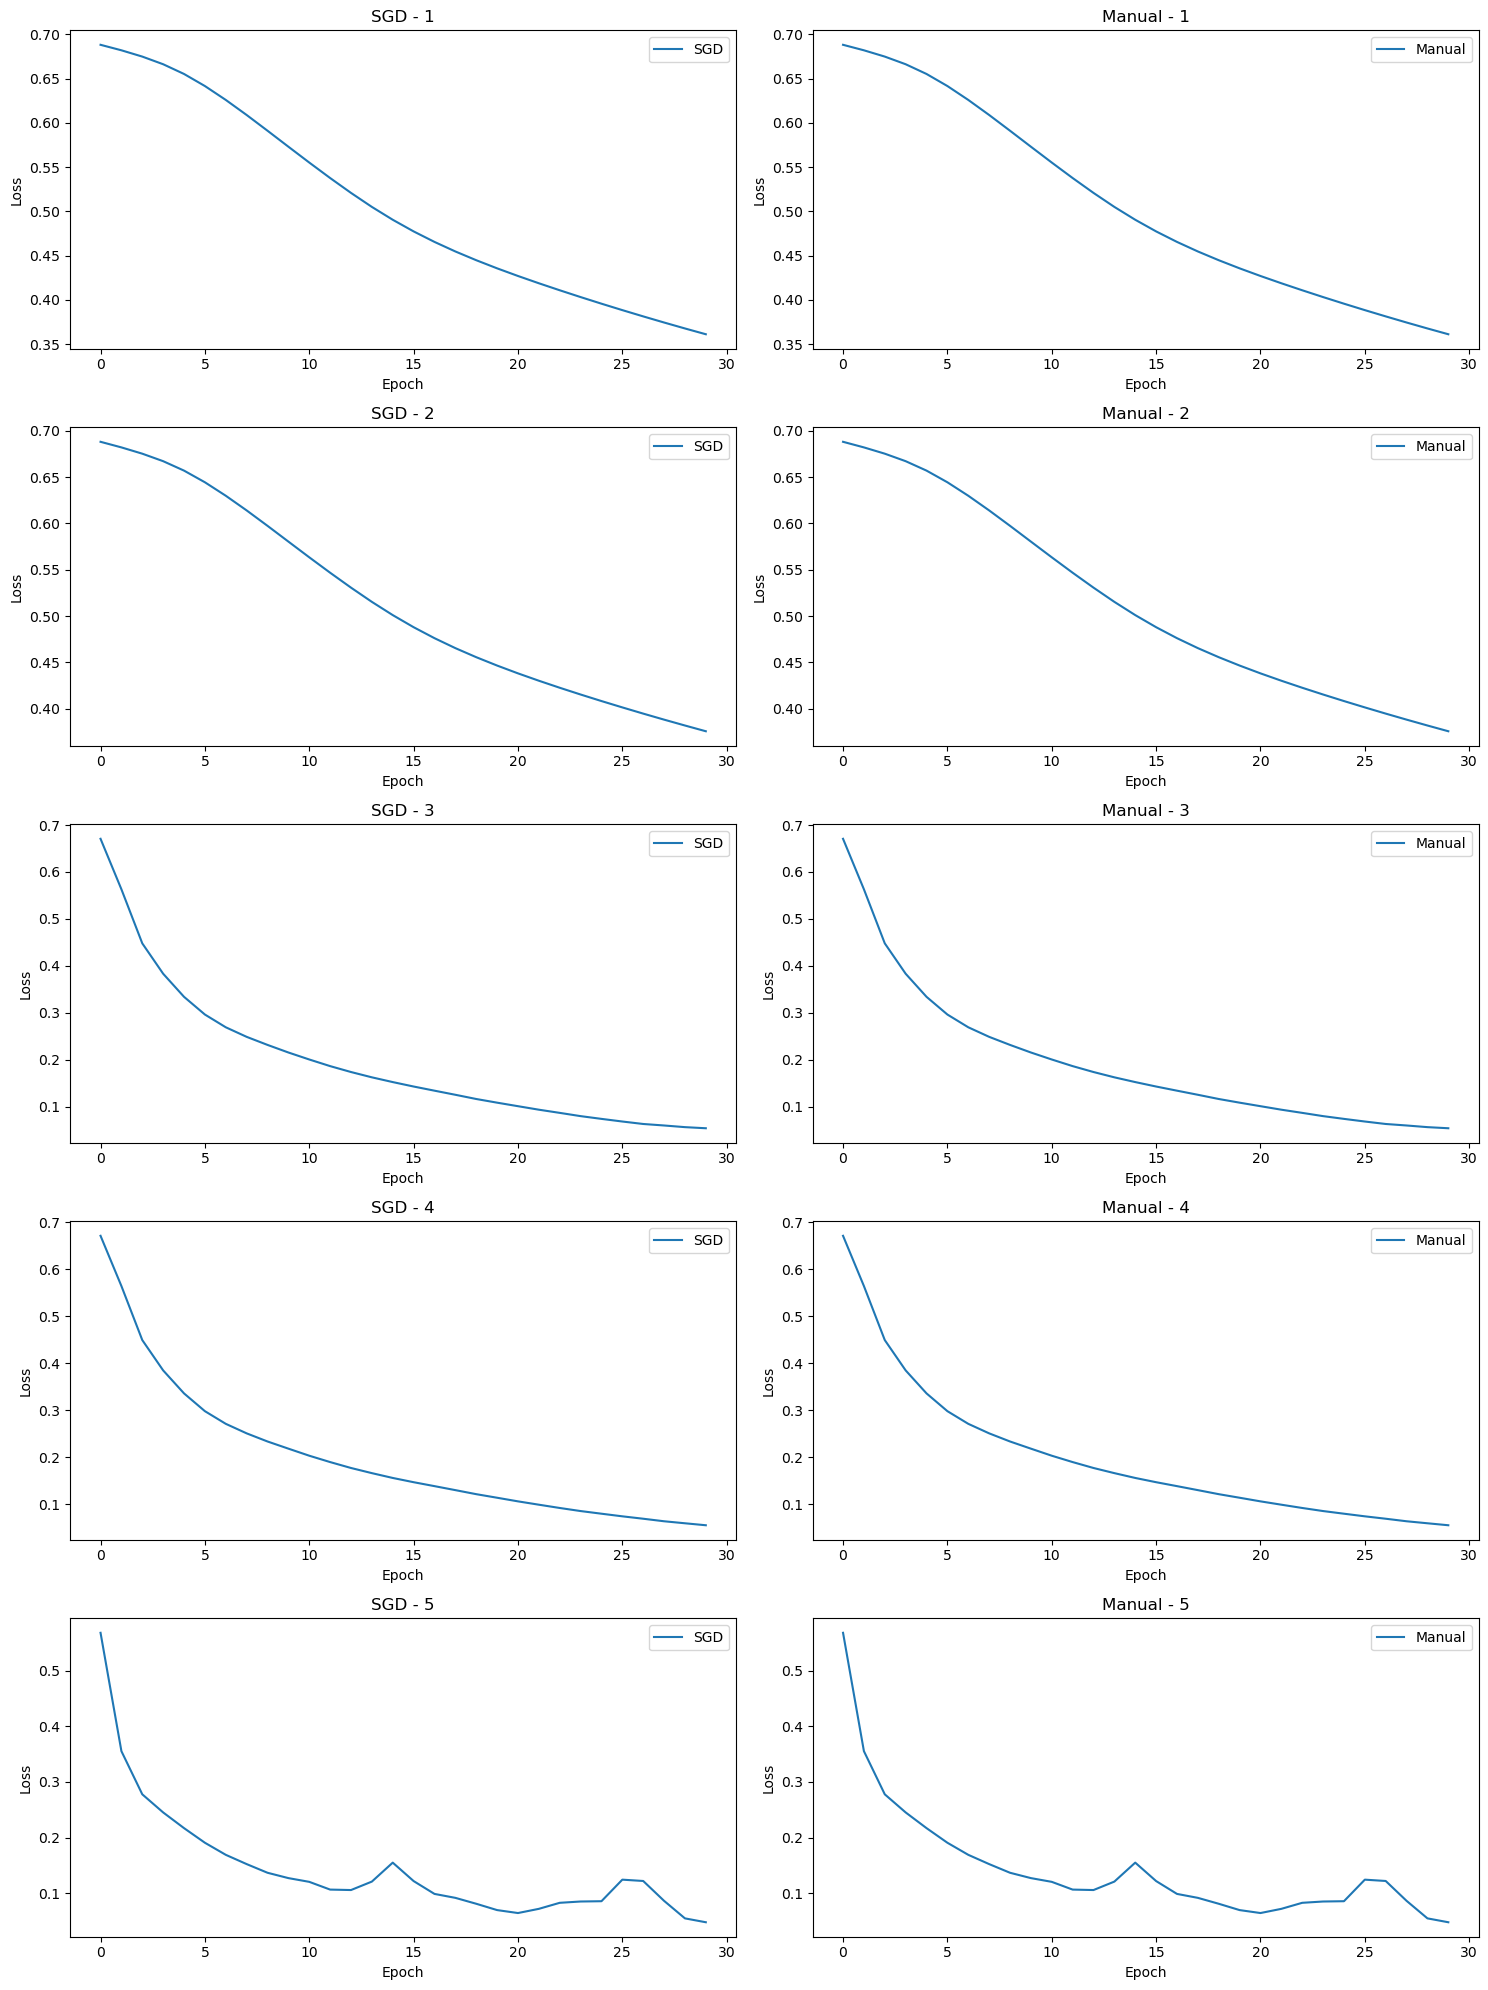

In [213]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(len(results)):
    train_losses, train_losses_manuel = results[i]
    axs[i, 0].plot(train_losses, label="SGD")
    axs[i, 0].set_title(f"SGD - {i+1}")
    axs[i, 0].set_xlabel("Epoch")
    axs[i, 0].set_ylabel("Loss")
    axs[i, 0].legend()

    axs[i, 1].plot(train_losses_manuel, label="Manual")
    axs[i, 1].set_title(f"Manual - {i+1}")
    axs[i, 1].set_xlabel("Epoch")
    axs[i, 1].set_ylabel("Loss")
    axs[i, 1].legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Or you can use subplots_adjust for more control over spacing
# plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

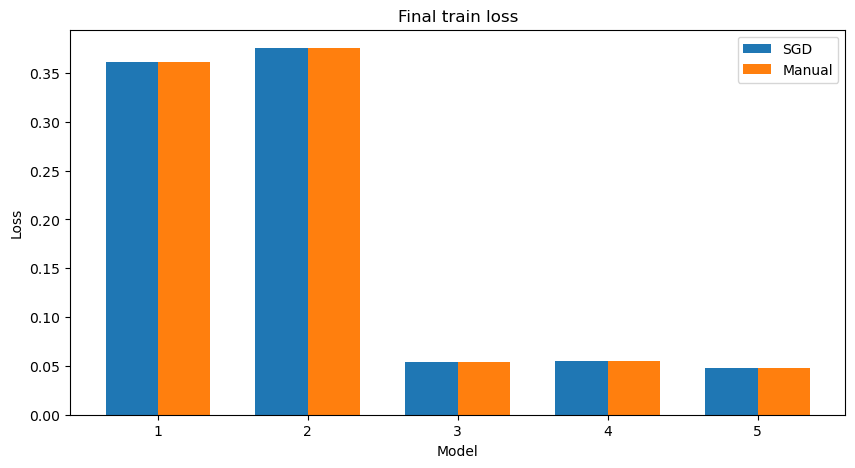

In [214]:
# plot the last train_loss from each model in a single plot bar
train_losses = [train_losses_1[-1], train_losses_2[-1], train_losses_3[-1], train_losses_4[-1], train_losses_5[-1]]
train_losses_manuel = [train_losses_manuel_1[-1], train_losses_manuel_2[-1], train_losses_manuel_3[-1], train_losses_manuel_4[-1], train_losses_manuel_5[-1]]
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(train_losses))
ax.bar(index, train_losses, bar_width, label="SGD")
ax.bar(index + bar_width, train_losses_manuel, bar_width, label="Manual")
ax.set_xlabel("Model")
ax.set_ylabel("Loss")
ax.set_title("Final train loss")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f"{i+1}" for i in range(len(train_losses))])
ax.legend()
plt.show()

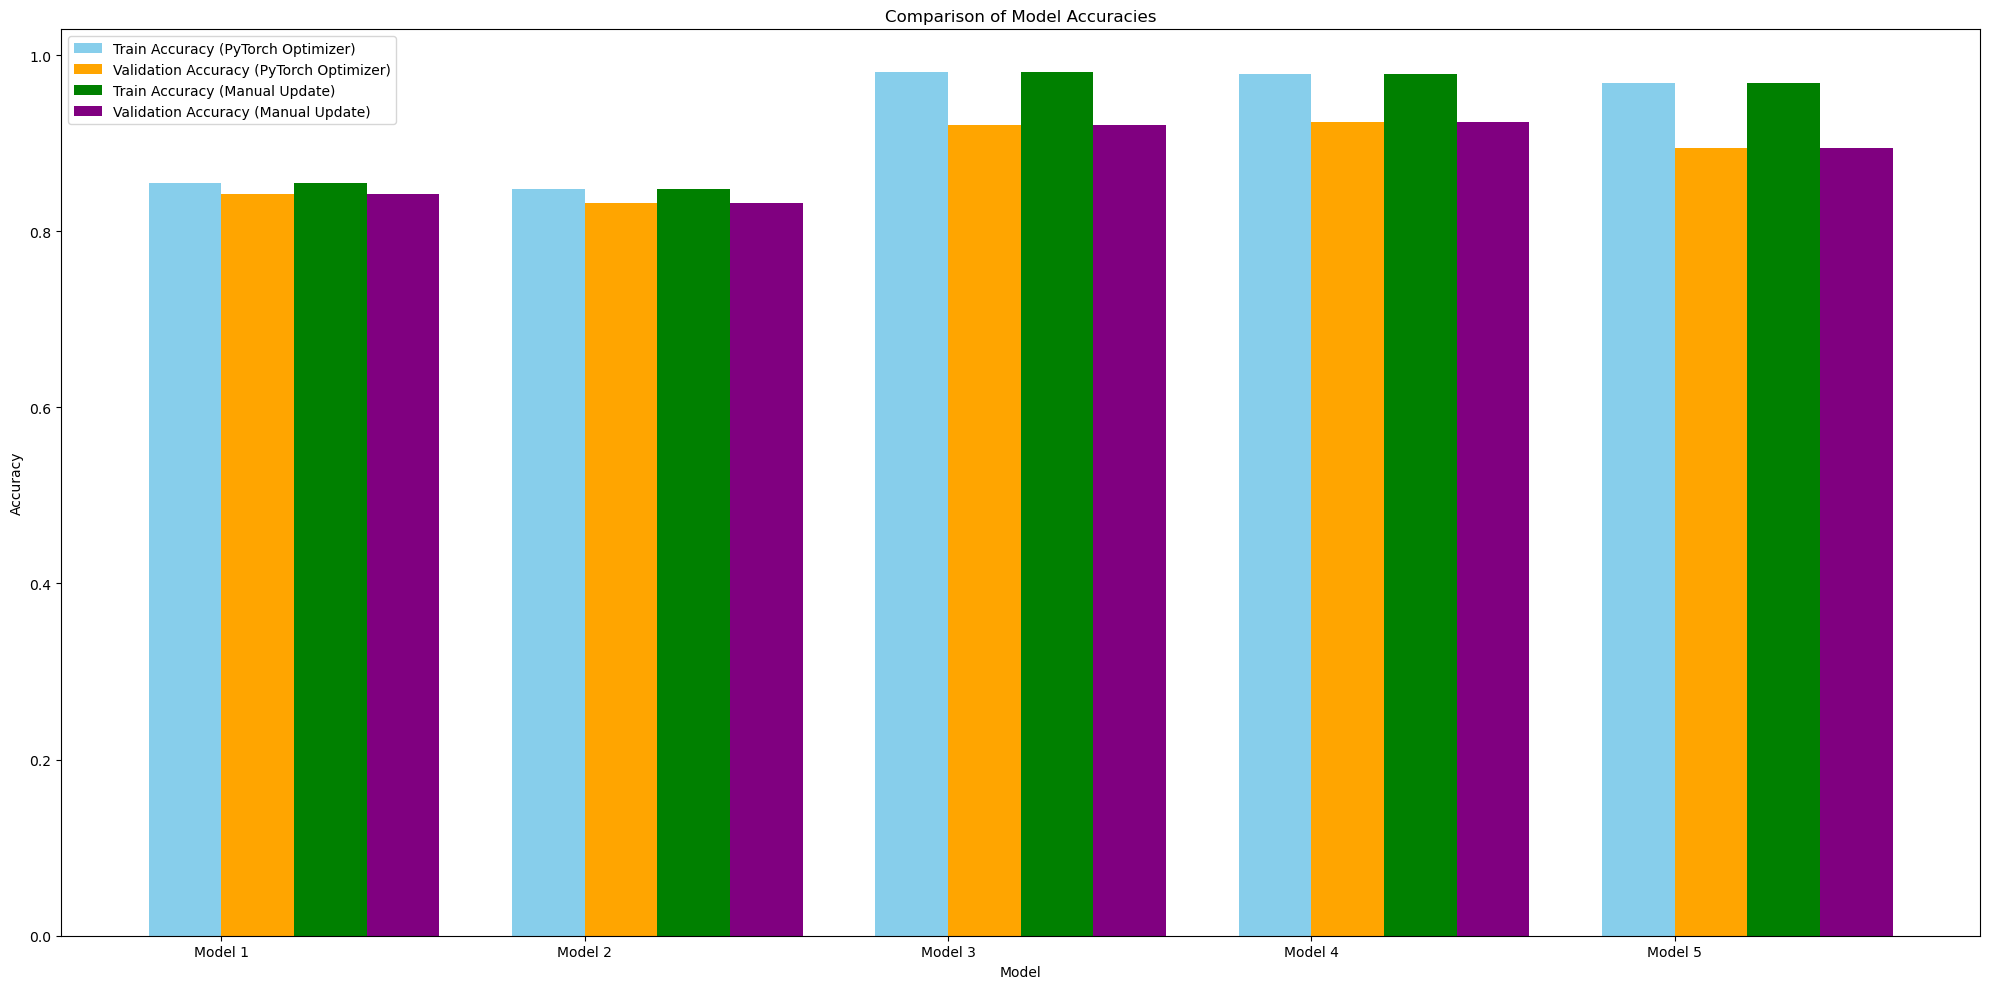

In [215]:
model_names = list(accuracies.keys())

model_names_string = []
for i in range(len(model_names)):
    model_names_string.append(f"Model {i+1}")

# Extract the accuracies
train_acc = [accuracies[model]['train'] for model in model_names]
val_acc = [accuracies[model]['val'] for model in model_names]
train_acc_manual = [accuracies[model]['train_manuel'] for model in model_names]
val_acc_manual = [accuracies[model]['val_manuel'] for model in model_names]

# Create a bar plot
plt.figure(figsize=(20, 10))

# Bar width and positions
bar_width = 0.2
x = range(len(model_names))

# Plotting the bars
plt.bar(x, train_acc, bar_width, label="Train Accuracy (PyTorch Optimizer)", color='skyblue')
plt.bar([p + bar_width for p in x], val_acc, bar_width, label="Validation Accuracy (PyTorch Optimizer)", color='orange')
# If you want to include manual update accuracies, you can uncomment these lines
plt.bar([p + bar_width * 2 for p in x], train_acc_manual, bar_width, label="Train Accuracy (Manual Update)", color='green')
plt.bar([p + bar_width * 3 for p in x], val_acc_manual, bar_width, label="Validation Accuracy (Manual Update)", color='purple')

# Set labels, title, and legend
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.xticks([p + bar_width / 2 for p in x], model_names_string)
plt.legend()
plt.tight_layout()

plt.show()


In [216]:
best_model = max(accuracies, key=lambda x: accuracies[x]['val'])
print(f"Best model: {best_model}")

# save the accuracies train and validation of the best model
best_model_train_acc = accuracies[best_model]['train']
best_model_val_acc = accuracies[best_model]['val']



Best model: MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [217]:
# test the best model
best_model = model4_1
test_accuracy = compute_accuracy(best_model, test_loader)
print(f"Test accuracy of the best model: {test_accuracy:.4f}")


Test accuracy of the best model: 0.9175


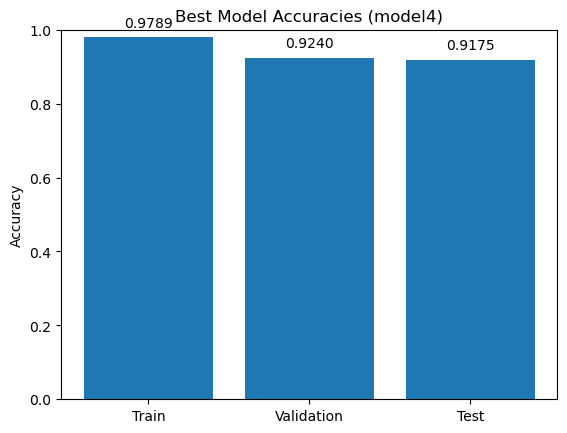

In [218]:
# Get the training, validation, and test accuracies of the best model and plot them
accuracies = [best_model_train_acc, best_model_val_acc, test_accuracy]
labels = ['Train', 'Validation', 'Test']

plt.bar(labels, accuracies)
plt.ylim(0, 1)

for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.02, f'{accuracy:.4f}', ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title('Best Model Accuracies (model4)')
plt.show()
